In [1]:
import numpy as np

from gradvi.inference import LinearRegression
from gradvi.tests import toy_priors
from gradvi.tests import toy_data

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

In [2]:
x, y, b, s2 = toy_data.get_linear_model(standardize = True, pve = 0.7, rho = 0.4)
prior = toy_priors.get_ash_scaled(k = 10, sparsity = None)

In [4]:
# ================
# Reparametrized objective
# ================
gv1 = LinearRegression(
        obj = "reparametrize",
        fit_intercept = False,
        debug = False, 
        display_progress = False, tol = 1e-8)
gv1.fit(x, y, prior)

2022-04-22 13:35:04,562 | gradvi.inference.linear_regression | INFO | Terminated at iteration 154.


In [9]:
# ================
# Direct objective 
# ================
gv2 = LinearRegression(
        obj = "direct",
        fit_intercept = False,
        debug = False,
        display_progress = False, 
        invert_method = "fssi-cubic", 
        tol = 1e-8)
gv2.fit(x, y, prior, b_init = gv1._init_params[0])

2022-04-22 13:35:06,806 | gradvi.inference.linear_regression | INFO | Terminated at iteration 391.


In [11]:
np.testing.assert_allclose(gv1.theta, gv2.theta, atol = 0.1, rtol = 1e-8)

In [12]:
np.testing.assert_allclose(gv1.coef, gv2.coef, atol = 0.1, rtol = 1e-8)

AssertionError: 
Not equal to tolerance rtol=1e-08, atol=0.1

Mismatched elements: 1 / 200 (0.5%)
Max absolute difference: 0.15226699
Max relative difference: 375.64726233
 x: array([ 8.444552e-04,  1.413080e-03,  5.856684e-04,  5.571913e-04,
       -2.327267e-03, -5.290921e-04, -1.028240e-03, -1.015928e-03,
       -3.755656e-04, -2.359571e-03,  1.418129e-03,  1.339722e-04,...
 y: array([ 5.405383e-04,  8.961133e-04,  3.435843e-04,  3.189552e-04,
       -1.782377e-03, -4.361260e-04, -8.122178e-04, -8.032215e-04,
       -3.203417e-04, -1.761665e-03,  8.422576e-04,  7.399439e-05,...

In [13]:
gv1.residual_var

33.92662183212068

In [14]:
gv2.residual_var

33.61043249277922

In [15]:
np.log(gv1.prior.w)

array([-9.19580286e-03, -1.36228160e+01, -2.70512552e+01, -1.39699375e+01,
       -4.69382859e+00, -2.49408561e+01, -4.49278463e+01, -6.39317486e+01,
       -8.10759211e+01, -9.60605456e+01])

In [16]:
np.log(gv2.prior.w)

array([-7.79050834e-03, -2.55895335e+01, -1.52600161e+01, -1.48860704e+01,
       -1.21571223e+01, -4.88195130e+00, -8.83674341e+00, -1.09640788e+01,
       -1.19909119e+01, -1.25920143e+01])

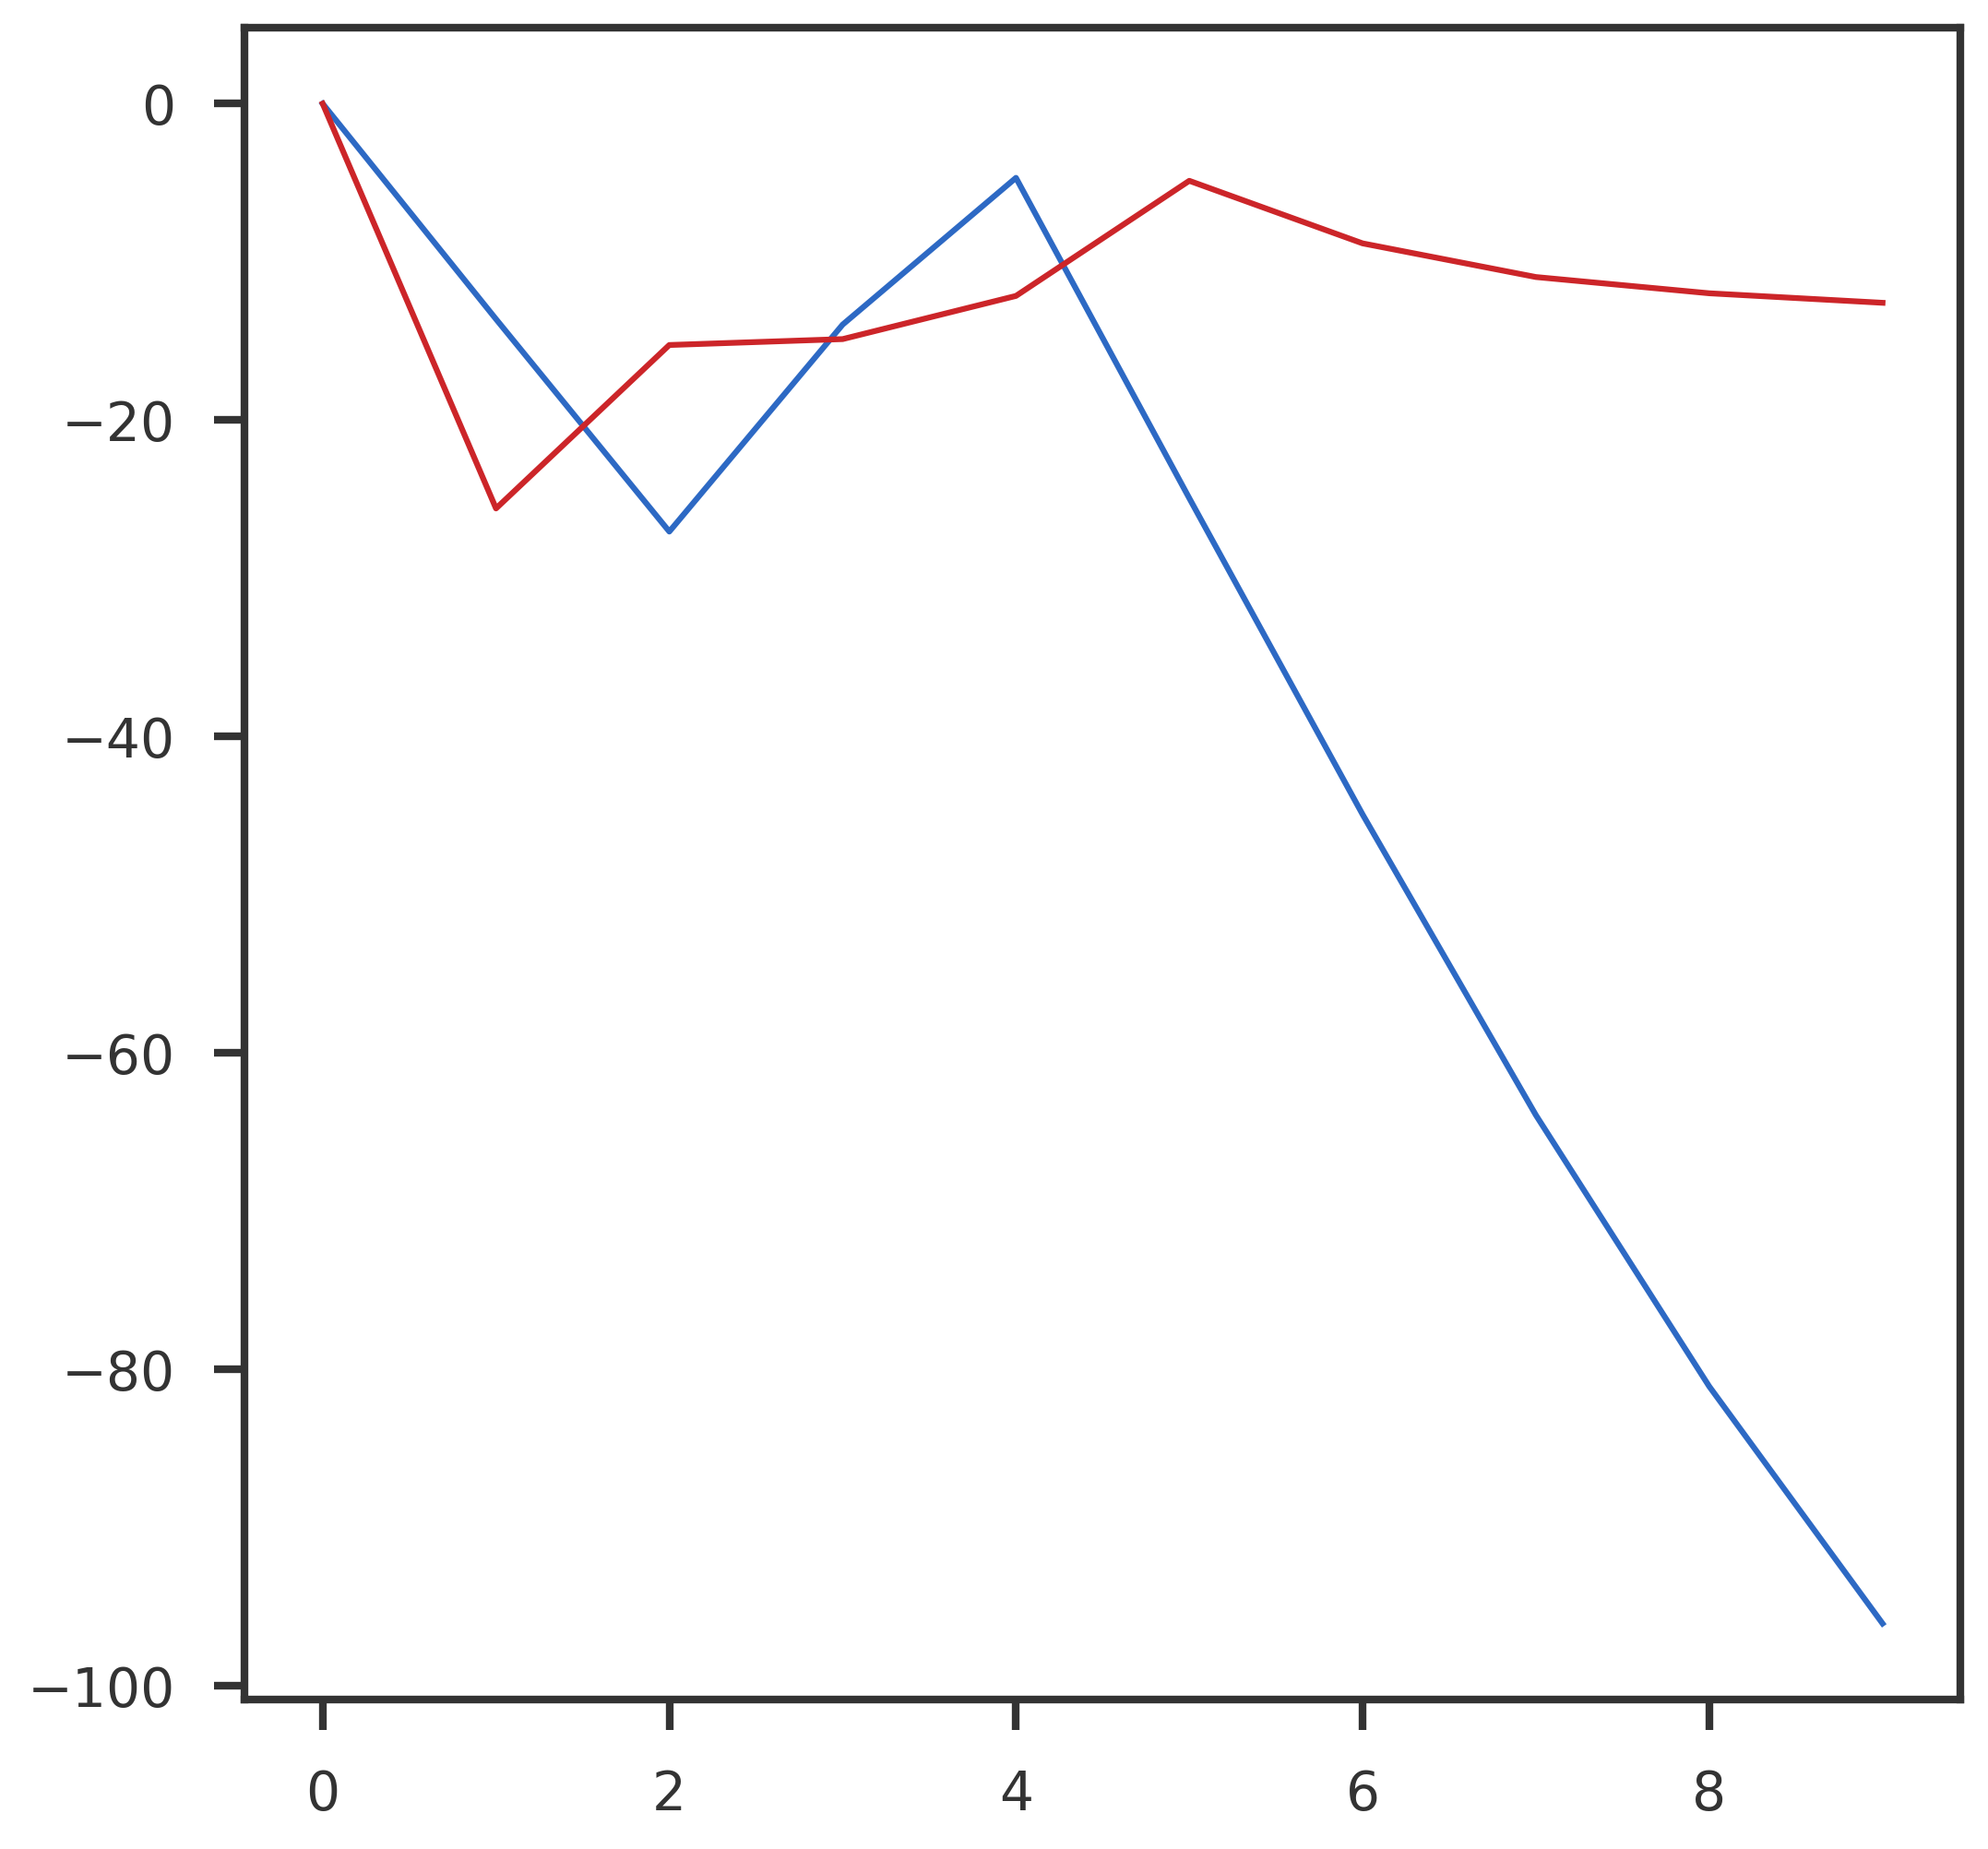

In [17]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
#ax1.scatter(np.log(gv1.prior.w), np.log(gv2.prior.w))
ax1.plot(np.arange(gv1.prior.k), np.log(gv1.prior.w))
ax1.plot(np.arange(gv2.prior.k), np.log(gv2.prior.w))
#mpl_utils.plot_diag(ax1)
plt.show()

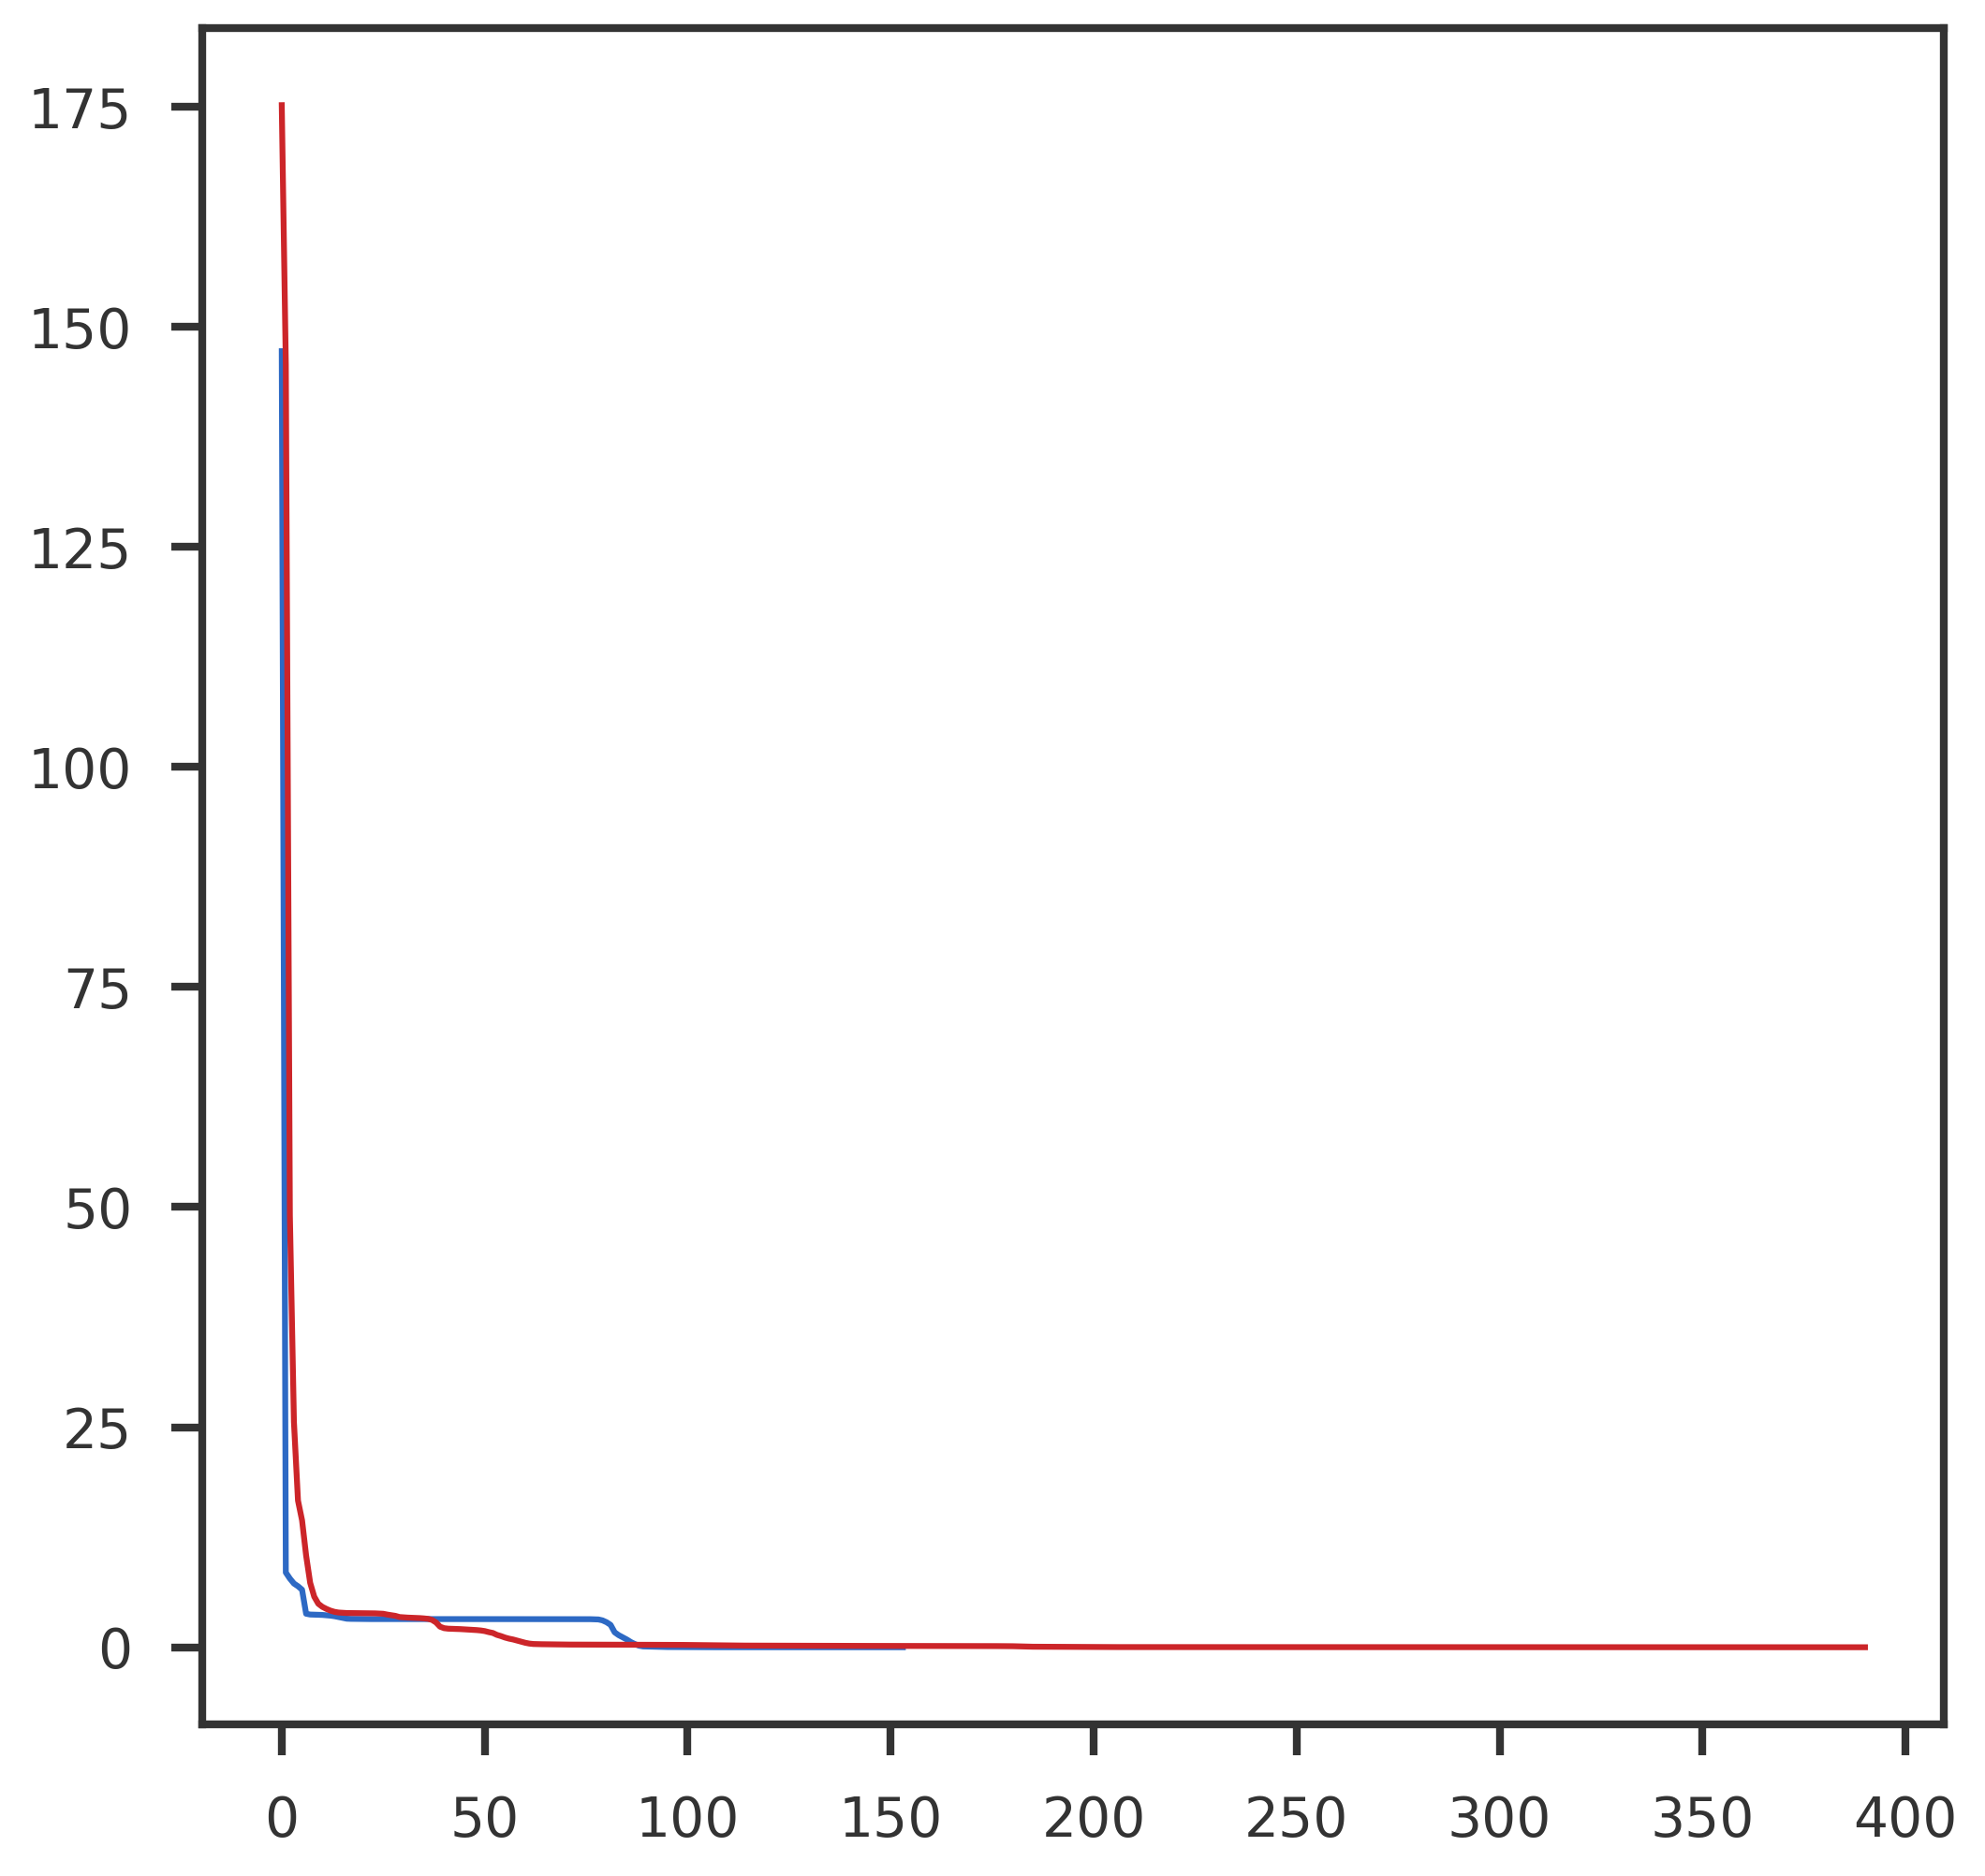

In [18]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
#ax1.scatter(np.log(gv1.prior.w), np.log(gv2.prior.w))
ax1.plot(np.arange(gv1.niter), gv1.obj_path - np.min(gv1.obj_path))
ax1.plot(np.arange(gv2.niter), gv2.obj_path - np.min(gv2.obj_path))
#mpl_utils.plot_diag(ax1)
plt.show()

In [25]:
np.testing.assert_almost_equal(gv1.fun, gv2.fun, decimal = 1)

AssertionError: 
Arrays are not almost equal to 1 decimals
 ACTUAL: -135.0524083512288
 DESIRED: -135.24961406531594

In [30]:
np.abs(gv1.fun - gv2.fun) < 1.5 * 10**(20)

True

In [32]:
1.5 * 10**(0)

1.5